In [1]:
import torch
from torch import nn # neural networks building blocks
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.0.1+cu118'

In [3]:
# data prep and load
weight = 0.7 # a
bias = 0.3 # b

# create some data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # size = (50, 1)
y = weight * X + bias # linear regression formula (y = ax + b)

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

In [5]:
# split data: training set, test set, validation set
# 80/20 train/test
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test)

(40, 10)

In [6]:
# visualize our X data
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
  """
    Plots training/test data and compares predictions.
  """
  plt.figure(figsize=(5, 3)) # other (10, 7)
  # Plot taining data in magenta
  plt.scatter(train_data, train_labels, c="m", s=4, label="Training data")
  # Plot test data in black
  plt.scatter(test_data, test_labels, c="k", s=4, label="Testing data")

  if predictions is not None:
    # Plot prediction in blue
    plt.scatter(test_data, predictions, c="b", s=4, label="Predictions")

  # add legend
  plt.legend(prop={"size":9}) #font size is 9


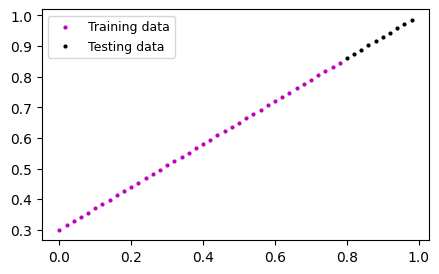

In [7]:
plot_prediction()

In [8]:
# build a linear regression model
# nn.Parameter, what parameters our model should learn
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Initialize model parameters
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True, # gradiant descent
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True, # gradiant descent
                                         dtype=torch.float))
  # defines the computation in the model
  # required from nn.Model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.weights * x + self.bias

In [9]:
# create a random seed
torch.manual_seed(42)
# create an instance of the model
model_0 = LinearRegressionModel()

# check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
# making predictions via torch.inference_mode()
with torch.inference_mode(): # context manager, doesn't track the gradient since we are just testing
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [12]:
# previous version of torch.inference_mode()
# does not track the gradient during inference/testing
with torch.no_grad():
  y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

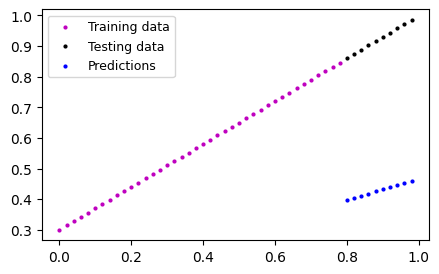

In [13]:
plot_prediction(predictions=y_preds)

In [14]:
# loss function/ cost function / criterion -- all the same concept!, It measures how poor the model predictions are with respect to the ideal outputs
loss_fn = nn.L1Loss() # Mean Absolute Error avg(abs(x-x0))

# Optimizer - take into account the loss and adjusts the model's parameters (weight, bias) to improve/minimize loss
# Stocatic Gradient Descent
optimizer = torch.optim.SGD(model_0.parameters(), # the model paramters
                            0.01) # learning rate - the step with which the bias/weight will change

In [15]:
# Training/Testing Loop
# 0. loop through the data
# 1. forward pass/propagation: from input to the output, make predictions
# 2. calculate the loss (predictions vs ground truth)
# 3. optimizer zero grad
# 4. loss backward - move backwards through the network to compute the gradients of each of the paramenters of our model wrt the loss
# 5. optimizer step - adjust model parameters to improve loss

torch.manual_seed(42)

# An epoch is one loop through the data
epochs = 200

# track different values
epoch_count = []
loss_values = []
test_loss_values = []


for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # sets all parameters that need a gradient

  # 1. forward
  y_pred = model_0(X_train)

  # 2. calculate the loss function
  loss = loss_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad() # start fresh, every epoch

  # 4. loss backward, backpropagation on the loss function (computes the gradient of every parameter with requires_grad=True)
  loss.backward()

  # 5. optimizer step SGD, update the parameters
  optimizer.step()

  ### Testing
  model_0.eval() # turns off settings not needed in testing
  with torch.inference_mode(): # the gradient tracking
    # 0. do the forward pass
    test_pred = model_0(X_test)
    # 1. compute test loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {test_loss}")

    # print weights/bias update
    print(model_0.state_dict())

Epoch: 0 | Train Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Train Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Train Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Train Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Train Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Train Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Train Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', 

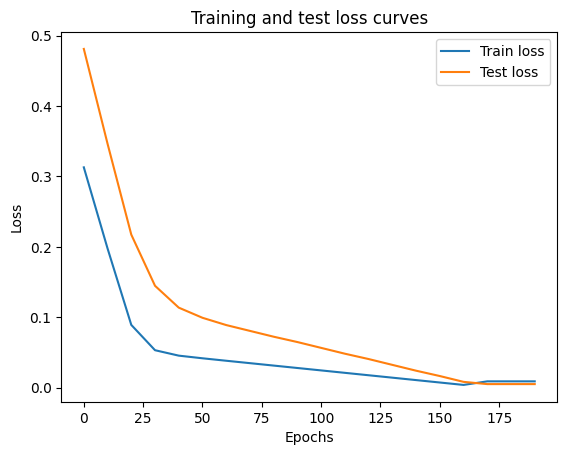

In [16]:
# plot loss curves
# loss_values is a list, convert it in a tensor
plt.plot(epoch_count, torch.tensor(loss_values), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

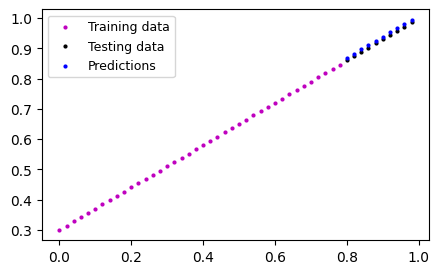

In [17]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_prediction(predictions=y_preds_new)

In [18]:
# saving a model in pytorch
from pathlib import Path

# create model directory
# MODEL_PATH = Path("models") # in the current enviroment
MODEL_PATH = Path("/content/drive/MyDrive/Colab Notebooks/models") # on drive
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

# save the model state_dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving model to /content/drive/MyDrive/Colab Notebooks/models/01_pytorch_workflow_model_0.pth


In [19]:
!ls -la "/content/drive/MyDrive/Colab Notebooks/"

total 241
-rw------- 1 root root   8884 Jul 27 14:44 00_ese.ipynb
-rw------- 1 root root  63060 Jul 27 11:13 00_fundamentals.ipynb
-rw------- 1 root root 169401 Aug  4 14:46 01_workflow.ipynb
drwx------ 2 root root   4096 Aug 13 09:02 models


In [20]:
# load model via state_dict (we didn't save the whole model)
model_00 = LinearRegressionModel() #subclass of nn.Module
model_00.load_state_dict(torch.load(MODEL_SAVE_PATH))

print(f"original state dict: {model_0.state_dict()}")
print(f"loaded state dict: {model_00.state_dict()}")

original state dict: OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
loaded state dict: OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])


In [21]:
# make some predictions
model_00.eval()
with torch.inference_mode():
  loaded_preds = model_00(X_test)


model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

# compare
loaded_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [22]:
# Putting it all together
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.0.1+cu118'

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [24]:
!nvidia-smi

Sun Aug 13 09:02:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
# build data
weight = 0.9
bias = 0.4

start = 0
end = 1
step = 0.015
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = X*weight + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0150],
         [0.0300],
         [0.0450],
         [0.0600]]),
 tensor([[0.4000],
         [0.4135],
         [0.4270],
         [0.4405],
         [0.4540]]))

In [26]:
# split data
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(53, 53, 14, 14)

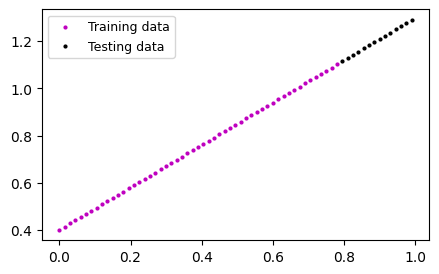

In [27]:
plot_prediction(X_train, y_train, X_test, y_test)

In [28]:
# build model
class LinearRegressionModelX(nn.Module):

  def __init__(self):
    super().__init__()
    # vesion 0
    #self.weight = nn.Parameter(torch.rand(size=(1,), requires_grad=True, device=device))
    #self.bias = nn.Parameter(torch.rand(size=(1,), requires_grad=True, device=device))
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x: torch.tensor) -> torch.tensor:
    # return  x*self.weight + self.bias
    return self.linear_layer(x)


torch.manual_seed(22)
model_1 = LinearRegressionModelX()
model_1, model_1.state_dict()

(LinearRegressionModelX(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.2682]])),
              ('linear_layer.bias', tensor([0.4050]))]))

In [29]:
# model to gpu/device
print(next(model_1.parameters()).device)
model_1.to(device) # send model to GPU
print(next(model_1.parameters()).device)


# data to gpu/device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

cpu
cuda:0


In [30]:
# loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [31]:
# training
torch.manual_seed(134)
epochs = 300

for epoch in range(epochs):
  model_1.train()

  # forward pass
  y_pred = model_1(X_train)

  # loss
  loss = loss_fn(y_pred, y_train)

  # zero_grad
  optimizer.zero_grad()

  # backprop
  loss.backward()

  # optim step/direction
  optimizer.step()

  ## testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # print out
  if epoch % 20:
    print(f"E:{epoch} Train Loss:{loss} | Test Loss:{test_loss}")

E:1 Train Loss:0.3524603247642517 | Test Loss:0.7951359152793884
E:2 Train Loss:0.2870626747608185 | Test Loss:0.7046163082122803
E:3 Train Loss:0.24590112268924713 | Test Loss:0.6317170858383179
E:4 Train Loss:0.22029906511306763 | Test Loss:0.5772464275360107
E:5 Train Loss:0.20508277416229248 | Test Loss:0.5322932004928589
E:6 Train Loss:0.19479317963123322 | Test Loss:0.4970594346523285
E:7 Train Loss:0.18779431283473969 | Test Loss:0.4717472195625305
E:8 Train Loss:0.18276992440223694 | Test Loss:0.45147156715393066
E:9 Train Loss:0.17848917841911316 | Test Loss:0.4311958849430084
E:10 Train Loss:0.1745813935995102 | Test Loss:0.41600731015205383
E:11 Train Loss:0.17098276317119598 | Test Loss:0.40595629811286926
E:12 Train Loss:0.16756342351436615 | Test Loss:0.3959052860736847
E:13 Train Loss:0.16414408385753632 | Test Loss:0.3858542740345001
E:14 Train Loss:0.16072477400302887 | Test Loss:0.37580326199531555
E:15 Train Loss:0.15730544924736023 | Test Loss:0.365752249956131
E:16

In [32]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.8165]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3786], device='cuda:0'))])

In [33]:
weight, bias

(0.9, 0.4)

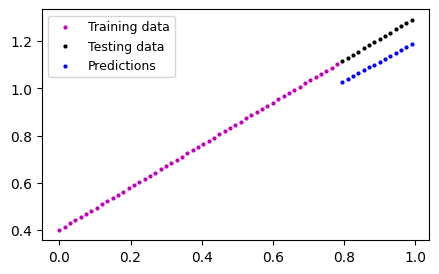

In [34]:
# test and plot
model_1.eval()
with torch.inference_mode():
  test_y_preds = model_1(X_test)


plot_prediction(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), predictions=torch.Tensor(test_y_preds.cpu()))

In [38]:
from pathlib import Path
MPath = Path("/content/drive/MyDrive/Colab Notebooks/models")
MPath.mkdir(parents=True, exist_ok=True)

MName = "01_pytorch_workflow_model_x.pth"
MSavePath = MPath / MName

print(f"Saving model to: {MSavePath}")
torch.save(obj=model_1.state_dict(),
           f=MSavePath)

Saving model to: /content/drive/MyDrive/Colab Notebooks/models/01_pytorch_workflow_model_x.pth


In [41]:
# load a pytorch model

## new instance
lmodelx = LinearRegressionModelX()
## load state dict
lmodelx.load_state_dict(torch.load(MSavePath))

<All keys matched successfully>

In [43]:
lmodelx.state_dict()
lmodelx.to(device)

LinearRegressionModelX(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [44]:
lmodelx.eval()
with torch.inference_mode():
  lmodelx_preds = lmodelx(X_test)

test_y_preds == lmodelx_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')